In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('../Q1/男胎检测数据_预处理后.csv')
data

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,Y染色体浓度,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康
0,1,A001,31,160.0,72.0,2023-02-01,自然受孕,2023-04-29,1,11.86,...,0.025936,0.038061,0.377069,0.389803,0.399399,0.027484,NaN,1,0,是
1,2,A001,31,160.0,73.0,2023-02-01,自然受孕,2023-05-31,2,15.86,...,0.034887,0.059572,0.371542,0.384771,0.391706,0.019617,NaN,1,0,是
2,3,A001,31,160.0,73.0,2023-02-01,自然受孕,2023-06-25,3,20.14,...,0.066171,0.075995,0.377449,0.390582,0.399480,0.022312,NaN,1,0,是
3,4,A001,31,160.0,74.0,2023-02-01,自然受孕,2023-07-16,4,22.86,...,0.061192,0.052305,0.375613,0.389251,0.397212,0.023280,NaN,1,0,是
4,5,A002,32,149.0,74.0,2023-11-09,自然受孕,2024-02-19,1,13.86,...,0.059230,0.059708,0.380260,0.393618,0.404868,0.024212,NaN,2,1,否
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,A266,30,159.0,83.4,NaN,自然受孕,2023-05-02,4,17.71,...,0.099052,0.056686,0.376861,0.389914,0.397090,0.017951,T18,1,0,是
1078,1079,A267,28,155.0,73.8,NaN,自然受孕,2023-05-17,1,11.57,...,0.098706,0.023663,0.377597,0.387901,0.404293,0.022549,T21,1,0,是
1079,1080,A267,28,155.0,74.1,NaN,自然受孕,2023-05-24,2,12.57,...,0.102088,0.080264,0.379041,0.391748,0.400433,0.021330,NaN,1,0,是
1080,1081,A267,28,155.0,74.7,NaN,自然受孕,2023-05-31,3,13.57,...,0.109855,0.074050,0.379107,0.388544,0.401030,0.022013,NaN,1,0,是


# 筛选与字段规范

In [3]:
data=data[['孕妇代码','检测孕周','孕妇BMI','Y染色体浓度']]
data

,孕妇代码,检测孕周,孕妇BMI,Y染色体浓度
0,A001,11.86,28.125000,0.025936
1,A001,15.86,28.515625,0.034887
2,A001,20.14,28.515625,0.066171
3,A001,22.86,28.906250,0.061192
4,A002,13.86,33.331832,0.059230
...,...,...,...,...
1077,A266,17.71,32.969881,0.099052
1078,A267,11.57,30.703133,0.098706
1079,A267,12.57,30.825814,0.102088
1080,A267,13.57,31.107551,0.109855


In [4]:
data=data[(data['检测孕周']>=10) & (data['检测孕周']<26)]
data.describe()

,检测孕周,孕妇BMI,Y染色体浓度
count,1073.000000,1073.000000,1073.000000
mean,16.761808,32.283321,0.077089
std,3.987793,2.972165,0.033607
min,11.000000,20.703125,0.010004
25%,13.290000,30.185195,0.051152
50%,16.000000,31.826510,0.074872
75%,20.000000,33.932236,0.098862
max,25.710000,46.875000,0.234218


## 首次达标区间构造

In [5]:
# 阈值
thr = 0.04

# 清洗与排序
data = data.copy()
data["检测孕周"] = pd.to_numeric(data["检测孕周"], errors="coerce")
data["Y染色体浓度"] = pd.to_numeric(data["Y染色体浓度"], errors="coerce")
data = data.dropna(subset=["检测孕周", "Y染色体浓度"])
data = data.sort_values(["孕妇代码", "检测孕周"], ascending=[True, True])


# 分组构造首次达标区间
def first_hit_interval(g: pd.DataFrame) -> pd.Series:
    bmi = g["孕妇BMI"].dropna().iloc[0] if g["孕妇BMI"].notna().any() else np.nan
    # convert to plain numpy float arrays to avoid ExtensionArray comparison issues
    y = g["Y染色体浓度"].to_numpy(dtype=float)
    weeks = g["检测孕周"].to_numpy(dtype=float)

    hit_idx = np.where(y >= thr)[0]
    if hit_idx.size == 0:
        # 右删失：T* > C
        C = weeks[-1]
        L, R, censor = C, np.inf, "right"
    else:
        r_pos = int(hit_idx[0])
        R = weeks[r_pos]
        if r_pos == 0:
            # 左删失：(-inf, R]
            L, censor = -np.inf, "left"
        else:
            # 区间删失：(L, R]
            L, censor = weeks[r_pos - 1], "interval"

    return pd.Series(
        {"id": g["孕妇代码"].iloc[0], "BMI": bmi, "L": L, "R": R, "censor_type": censor}
    )


intervals = (
    data.groupby("孕妇代码", group_keys=False)
    .apply(first_hit_interval)
    .reset_index(drop=True)
)

intervals

C:\Users\HP\AppData\Local\Temp\ipykernel_62404\706680993.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(first_hit_interval)


,id,BMI,L,R,censor_type
0,A001,28.125000,15.86,20.14,interval
1,A002,33.331832,-inf,13.86,left
2,A003,30.742188,-inf,13.00,left
3,A004,28.641243,-inf,11.00,left
4,A005,29.955556,-inf,12.29,left
...,...,...,...,...,...
262,A263,29.346687,-inf,12.57,left
263,A264,32.471062,-inf,11.71,left
264,A265,33.719678,-inf,11.71,left
265,A266,32.135095,-inf,13.71,left


# 条件推理树（CIT）

## 特征构造

In [6]:
# 特征构造（每人一条）

# 右删失下界代理的增量（周）
delta_week = 1.0

feat = intervals.copy()

# 删失标记：right=1，其余=0
feat["censored"] = (feat["censor_type"] == "right").astype(int)

# 达标时间代理：
# - 区间/左删失：用 R（首次达标周）
# - 右删失：用 C+Δ，这里 C=L（上一步构造里 right 情况把 L 设为最后检测周）
feat["t_proxy"] = np.where(feat["censored"] == 1, feat["L"] + delta_week, feat["R"])


# 简单 z-score 标准化（避免 std=0 的数值问题）
def zscore(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sigma = s.std(ddof=0)
    sigma = 1.0 if (not np.isfinite(sigma) or sigma == 0) else sigma
    return (s - mu) / sigma


feat["x1"] = zscore(feat["BMI"])
feat["x2"] = zscore(feat["t_proxy"])

# 右删失样本较低权重
feat["sample_weight"] = np.where(feat["censored"] == 1, 0.5, 1.0)

# 输出特征表（保留原值便于核查）
features = feat[["id", "x1", "x2", "censored", "sample_weight", "BMI", "t_proxy"]]
features

,id,x1,x2,censored,sample_weight,BMI,t_proxy
0,A001,-1.246572,2.205301,0,1.0,28.125000,20.14
1,A002,0.497095,0.030966,0,1.0,33.331832,13.86
2,A003,-0.370127,-0.266793,0,1.0,30.742188,13.00
3,A004,-1.073692,-0.959256,0,1.0,28.641243,11.00
4,A005,-0.633554,-0.512617,0,1.0,29.955556,12.29
...,...,...,...,...,...,...,...
262,A263,-0.837453,-0.415672,0,1.0,29.346687,12.57
263,A264,0.208840,-0.713432,0,1.0,32.471062,11.71
264,A265,0.626977,-0.713432,0,1.0,33.719678,11.71
265,A266,0.096331,-0.020968,0,1.0,32.135095,13.71


## 分组

In [7]:
from typing import Tuple
from scipy.stats import mannwhitneyu

# 基于 BMI 的条件推理树（CIT）递归分组
df = features.copy()
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["BMI", "t_proxy"])
df = df.sort_values("BMI").reset_index(drop=True)

# 超参数 (adjusted for better model performance)
alpha = 0.3           # 显著性水平 (increased to reduce over-splitting)
max_depth = 5          # 最大深度
min_leaf = int(0.1 * len(df)) # 叶子最小样本数 (increased to 10% for fewer groups)
n_thresholds = 200      # 候选阈值个数（精细化搜索颗粒度）

def best_split(data) -> Tuple[float, float, int, int]:
    bmis = data["BMI"].to_numpy()
    y = data["t_proxy"].to_numpy()
    if len(data) < 2 * min_leaf:
        return np.nan, 1.0, len(data), 0

    qs = np.linspace(0.1, 0.9, n_thresholds)
    cands = np.unique(np.quantile(bmis, qs))

    # 只保留左右子节点都满足 min_leaf 的阈值
    valid_cands = []
    for thr in cands:
        nl = (bmis <= thr).sum()
        nr = len(bmis) - nl
        if nl >= min_leaf and nr >= min_leaf:
            valid_cands.append(thr)

    if not valid_cands:
        return np.nan, 1.0, len(data), 0

    best_p, best_thr, best_nl, best_nr = 1.0, np.nan, 0, 0
    for thr in valid_cands:
        left = y[bmis <= thr]
        right = y[bmis > thr]
        _, p = mannwhitneyu(left, right, alternative="two-sided", method="asymptotic")
        if p < best_p:
            best_p, best_thr = p, thr
            best_nl, best_nr = len(left), len(right)

    # 返回的第二个值用作 grow 中的显著性判定，这里直接用原始 p
    return best_thr, best_p, best_nl, best_nr

leaves = []  # 存储叶子结点区间及统计
def grow(data, depth: int, lo: float, hi: float):
    thr, p_adj, nl, nr = best_split(data)
    # 停止条件：深度、无有效阈值或不显著
    if (depth >= max_depth) or (not np.isfinite(thr)) or (p_adj >= alpha):
        leaves.append({
            "lo": lo,
            "hi": hi,
            "depth": depth,
            "n": int(len(data)),
            "bmi_min": float(data["BMI"].min()),
            "bmi_max": float(data["BMI"].max()),
            "t_median": float(data["t_proxy"].median()),
        })
        return
    left = data[data["BMI"] <= thr]
    right = data[data["BMI"] > thr]
    grow(left, depth + 1, lo, thr)
    grow(right, depth + 1, thr, hi)

grow(df, depth=0, lo=-np.inf, hi=np.inf)

# 规范化叶子顺序并赋组号
leaves = sorted(leaves, key=lambda x: (x["lo"], x["hi"]))
for gid, leaf in enumerate(leaves):
    leaf["group"] = gid

def map_group_by_bmi(bmi):
    if pd.isna(bmi):
        return np.nan
    for leaf in leaves:
        if leaf["lo"] < bmi <= leaf["hi"]:
            return leaf["group"]
    # 边界兜底：若未命中则按最接近区间归类（通常不会触发）
    return len(leaves) - 1

features_cit = features.copy()
features_cit["group"] = features_cit["BMI"].apply(map_group_by_bmi)
features_cit

,id,x1,x2,censored,sample_weight,BMI,t_proxy,group
0,A001,-1.246572,2.205301,0,1.0,28.125000,20.14,0
1,A002,0.497095,0.030966,0,1.0,33.331832,13.86,5
2,A003,-0.370127,-0.266793,0,1.0,30.742188,13.00,3
3,A004,-1.073692,-0.959256,0,1.0,28.641243,11.00,0
4,A005,-0.633554,-0.512617,0,1.0,29.955556,12.29,2
...,...,...,...,...,...,...,...,...
262,A263,-0.837453,-0.415672,0,1.0,29.346687,12.57,1
263,A264,0.208840,-0.713432,0,1.0,32.471062,11.71,5
264,A265,0.626977,-0.713432,0,1.0,33.719678,11.71,5
265,A266,0.096331,-0.020968,0,1.0,32.135095,13.71,4


In [8]:
# 分组区间与统计输出
leaves_df = pd.DataFrame(leaves).sort_values(["group"]).reset_index(drop=True)

def _fmt(x):
    if not np.isfinite(x):
        return "-inf" if x < 0 else "+inf"
    return f"{x:.2f}"

leaves_df["bmi_interval"] = leaves_df.apply(
    lambda r: f"({_fmt(r['lo'])}, {_fmt(r['hi'])}]", axis=1
)

stats = (
    features_cit.groupby("group", as_index=False)
    .agg(
        n=("BMI", "size"),
        bmi_min=("BMI", "min"),
        bmi_median=("BMI", "median"),
        bmi_max=("BMI", "max"),
        t_median=("t_proxy", "median"),
        censored_rate=("censored", "mean"),
    )
    .merge(leaves_df[["group", "bmi_interval"]], on="group", how="left")
    .sort_values("group")
)

stats, features_cit

(   group   n    bmi_min  bmi_median    bmi_max  t_median  censored_rate  \
 0      0  39  20.703125   28.407877  29.090375     12.86       0.000000   
 1      1  34  29.123742   29.466010  29.891162     12.50       0.029412   
 2      2  33  29.899691   30.252363  30.483158     13.00       0.030303   
 3      3  33  30.483379   30.954271  31.559109     12.57       0.000000   
 4      4  26  31.563269   31.996086  32.368550     13.00       0.076923   
 5      5  59  32.405758   33.212210  34.301193     12.71       0.050847   
 6      6  43  34.339230   35.883634  46.875000     13.57       0.046512   
 
      bmi_interval  
 0   (-inf, 29.10]  
 1  (29.10, 29.89]  
 2  (29.89, 30.48]  
 3  (30.48, 31.56]  
 4  (31.56, 32.38]  
 5  (32.38, 34.31]  
 6   (34.31, +inf]  ,
        id        x1        x2  censored  sample_weight        BMI  t_proxy  \
 0    A001 -1.246572  2.205301         0            1.0  28.125000    20.14   
 1    A002  0.497095  0.030966         0            1.0  33.331

# 最佳nipt时点

## 按组构建区间删失对象

In [9]:
# 将分组信息并入区间数据
iv = intervals.merge(features_cit[["id", "group"]], on="id", how="left")


# Turnbull NPMLE（区间删失）实现
def turnbull_npmle(
    group_df: pd.DataFrame,
    max_iter: int = 5000,
    tol: float = 1e-8,
    eps_mass: float = 1e-12,
):
    """
    输入:
      group_df 需包含列: L, R, censor_type（left/right/interval）
    返回:
      dict: {support, mass, S, F}
    """
    g = group_df.copy()

    L = g["L"].to_numpy(dtype=float)
    R = g["R"].to_numpy(dtype=float)

    # 支持点 = 所有有限端点的并集（按升序）
    finite_L = L[np.isfinite(L)]
    finite_R = R[np.isfinite(R)]
    support = (
        np.unique(np.concatenate([finite_L, finite_R]))
        if (finite_L.size + finite_R.size) > 0
        else np.array([])
    )

    n = len(g)
    K = len(support)

    # 如果没有任何有限端点（极端：全右删失或全左删失），返回常数 S(t)=1 或 0 的退化情形
    if K == 0:
        # 这里将返回一个空支持集；调用方用阶梯函数求值时会得到常数 S=1（右删失主导）
        return {
            "support": support,
            "mass": np.array([]),
            "S": np.array([]),
            "F": np.array([]),
        }

    # 每个观测对应的可行支持点索引集合 J_i
    J = []
    for Li, Ri in zip(L, R):
        if np.isneginf(Li) and np.isfinite(Ri):
            idx = np.where(support <= Ri)[0]  # 左删失：(-inf, R]
        elif np.isposinf(Ri) and np.isfinite(Li):
            idx = np.where(support > Li)[0]  # 右删失：(L, +inf)
        else:
            # 区间删失：(L, R]
            idx = np.where((support > Li) & (support <= Ri))[0]
        if idx.size == 0:
            # 若该样本与任何支持点都不相交，强制用最近的一个支持点兜底，避免空集导致算法崩溃
            # 选择与(L,R]最近的支持点
            near = np.searchsorted(support, np.nan_to_num(Ri, nan=Li))  # 尝试靠近 R
            near = min(max(0, near - 1), K - 1)
            idx = np.array([near], dtype=int)
        J.append(idx)

    # 初始化概率质量：均匀
    p = np.full(K, 1.0 / K, dtype=float)

    # EM 迭代
    for it in range(max_iter):
        counts = np.zeros(K, dtype=float)
        for idx in J:
            denom = p[idx].sum()
            if denom <= 0:
                # 退化：当前区间无质量，按均匀分配到该观测可行集
                counts[idx] += 1.0 / len(idx)
            else:
                counts[idx] += p[idx] / denom
        p_new = counts / n

        # 去除极小质量并重标化（数值稳定）
        p_new[p_new < eps_mass] = 0.0
        s = p_new.sum()
        if s <= 0:
            # 罕见退化，回退为均匀
            p_new = np.full(K, 1.0 / K, dtype=float)
            s = 1.0
        else:
            p_new = p_new / s

        # 收敛判据
        if np.linalg.norm(p_new - p, ord=1) < tol:
            p = p_new
            break
        p = p_new

    # 生存函数（右连续阶梯）：S(t_j) = 1 - sum_{k<=j} p_k
    F = np.cumsum(p)
    S = 1.0 - F

    return {
        "support": support,
        "mass": p,
        "S": S,
        "F": F,
    }


# 生存阶梯函数求值
def eval_step_S(
    t: np.ndarray, support: np.ndarray, S_support: np.ndarray
) -> np.ndarray:
    """
    在任意 t 上按阶梯函数求 S(t)。
    规则：对于 t < support[0]，S=1；对 support[j-1] < t <= support[j]，S=S_support[j]
    """
    if support.size == 0:
        return np.ones_like(t, dtype=float)
    idx = np.searchsorted(support, t, side="right") - 1
    idx = np.clip(idx, -1, len(support) - 1)
    out = np.empty_like(t, dtype=float)
    # t 在首点之前
    mask_before = idx < 0
    out[mask_before] = 1.0
    # 其他
    mask_other = ~mask_before
    out[mask_other] = S_support[idx[mask_other]]
    return out


# 构建每组的 NPMLE 结果
group_surv = {}
for g in sorted(iv["group"].dropna().unique()):
    df_g = iv[iv["group"] == g][["L", "R", "censor_type"]].reset_index(drop=True)
    res = turnbull_npmle(df_g)
    group_surv[g] = res

# 将 NPMLE 结果整理为表（支持点上）
npmle_rows = []
for g, res in group_surv.items():
    sup = res["support"]
    mass = res["mass"]
    S = res["S"]
    F = res["F"]
    if sup.size == 0:
        # 无支持点时用空行占位
        npmle_rows.append(
            pd.DataFrame(
                {
                    "group": [g],
                    "t": [np.nan],
                    "S_npmle": [1.0],
                    "F_npmle": [0.0],
                    "mass": [0.0],
                }
            )
        )
    else:
        npmle_rows.append(
            pd.DataFrame(
                {"group": g, "t": sup, "S_npmle": S, "F_npmle": F, "mass": mass}
            )
        )
npmle_df = pd.concat(npmle_rows, ignore_index=True)

# 选择统一评估网格（按题意 10~26 周，可自行调整粒度）
t_grid = np.arange(10.0, 26.0 + 1e-9, 0.25)  # 精细化搜索颗粒度：步长从0.5减小到0.25

# 在统一网格上评估 S_g(t), F_g(t)
rows_grid = []
for g, res in group_surv.items():
    Sg = eval_step_S(t_grid, res["support"], res["S"])
    rows_grid.append(
        pd.DataFrame({"group": g, "t": t_grid, "S_npmle": Sg, "F_npmle": 1.0 - Sg})
    )
sf_grid_npmle = pd.concat(rows_grid, ignore_index=True)

# —— 离散时间生存模型（cloglog / logit 危害）用于平滑验证 ——
# 用 NPMLE 推导离散 hazard: h_j = p_j / S_{j-1}; 以 at_risk_j = n * S_{j-1} 作为试验次数（频数权重）
try:
    import statsmodels.api as sm

    has_sm = True
except Exception as e:
    has_sm = False
    print("未检测到 statsmodels，已跳过平滑验证。若需运行：pip install statsmodels")

smooth_rows = []
if has_sm:
    for g, res in group_surv.items():
        sup = res["support"]
        p = res["mass"]
        S = res["S"]

        if sup.size == 0:
            # 无支持点：S 恒为 1
            smooth_rows.append(
                pd.DataFrame(
                    {"group": g, "t": t_grid, "S_cloglog": 1.0, "S_logit": 1.0}
                )
            )
            continue

        # 计算离散 hazard 与风险集大小
        # S_prev[0]=1, S_prev[1]=S[0], ...
        S_prev = np.empty_like(S)
        S_prev[0] = 1.0
        S_prev[1:] = S[:-1]
        # 避免除零
        S_prev = np.clip(S_prev, 1e-12, 1.0)
        h = p / S_prev
        h = np.clip(h, 1e-9, 1 - 1e-9)

        # 以“比例 + 频数权重”的形式拟合 GLM
        # X: [1, t, t^2] 轻度平滑（可换成更高次或样条）
        X = np.column_stack([np.ones_like(sup), sup, sup**2])

        # at-risk 人数用 n * S_prev，n = 组内样本量
        n_group = int(iv[iv["group"] == g].shape[0])
        at_risk = np.maximum(1.0, n_group * S_prev)  # 至少为 1，稳定拟合

        # cloglog
        glm_cloglog = sm.GLM(
            h,
            X,
            family=sm.families.Binomial(link=sm.families.links.cloglog()),
            freq_weights=at_risk,
        ).fit(disp=0)

        # logit
        glm_logit = sm.GLM(
            h,
            X,
            family=sm.families.Binomial(link=sm.families.links.logit()),
            freq_weights=at_risk,
        ).fit(disp=0)

        # 预测在统一网格上的 hazard，并累乘得到 S(t)
        Xg = np.column_stack([np.ones_like(t_grid), t_grid, t_grid**2])
        h_cl = np.clip(glm_cloglog.predict(Xg), 1e-9, 1 - 1e-9)
        h_lo = np.clip(glm_logit.predict(Xg), 1e-9, 1 - 1e-9)

        # S(t_k) = ∏_{j<=k} (1 - h_j)
        S_cl = np.cumprod(1.0 - h_cl)
        S_lo = np.cumprod(1.0 - h_lo)

        smooth_rows.append(
            pd.DataFrame({"group": g, "t": t_grid, "S_cloglog": S_cl, "S_logit": S_lo})
        )

smooth_df = pd.concat(smooth_rows, ignore_index=True) if smooth_rows else pd.DataFrame()

# 合并网格上的 NPMLE 与平滑结果，便于对比
if not smooth_df.empty:
    compare_df = sf_grid_npmle.merge(smooth_df, on=["group", "t"], how="left")
else:
    compare_df = sf_grid_npmle.copy()

# 输出：
# npmle_df：各组在支持点上的 S/F 和概率质量
# sf_grid_npmle：各组在统一网格(10~26, 步长0.5)上的 S/F（阶梯评估）
# compare_df：若安装 statsmodels，则包含 S_cloglog / S_logit 的平滑对比
npmle_df, sf_grid_npmle, compare_df
# ...existing code...

d:\Develop\miniconda\envs\mcm\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The cloglog link alias is deprecated. Use CLogLog instead. The cloglog link alias will be removed after the 0.15.0 release.
  warnings.warn(
d:\Develop\miniconda\envs\mcm\Lib\site-packages\statsmodels\genmod\families\links.py:989: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-np.exp(z))
d:\Develop\miniconda\envs\mcm\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


(     group      t       S_npmle   F_npmle          mass
 0        0  11.00  2.499998e-01  0.750000  7.500002e-01
 1        0  11.29  2.499998e-01  0.750000  0.000000e+00
 2        0  11.43  2.499998e-01  0.750000  0.000000e+00
 3        0  11.57  2.499998e-01  0.750000  0.000000e+00
 4        0  11.71  2.499998e-01  0.750000  0.000000e+00
 ..     ...    ...           ...       ...           ...
 171      6  20.57  5.322328e-02  0.946777  5.198853e-07
 172      6  20.86  5.322328e-02  0.946777  0.000000e+00
 173      6  22.00  5.322328e-02  0.946777  0.000000e+00
 174      6  23.57  5.322328e-02  0.946777  0.000000e+00
 175      6  24.00  1.110223e-16  1.000000  5.322328e-02
 
 [176 rows x 5 columns],
      group      t       S_npmle  F_npmle
 0        0  10.00  1.000000e+00     0.00
 1        0  10.25  1.000000e+00     0.00
 2        0  10.50  1.000000e+00     0.00
 3        0  10.75  1.000000e+00     0.00
 4        0  11.00  2.499998e-01     0.75
 ..     ...    ...           ...     

## 求最早达标时点

In [10]:
# 阈值 π*（可调整）
pi_star = 0.95


# 点估计：直接基于前面计算好的 sf_grid_npmle（含每组在统一网格上的 F_npmle）
def earliest_t_from_grid(df_grid: pd.DataFrame, pi_star: float) -> pd.DataFrame:
    out = []
    for g, d in df_grid.groupby("group", sort=True):
        d = d.sort_values("t")
        mask = d["F_npmle"] >= pi_star
        if mask.any():
            t_star = float(d.loc[mask, "t"].iloc[0])
        else:
            t_star = np.nan  # 网格上尚未达到阈值
        out.append({"group": g, "t_star": t_star})
    return pd.DataFrame(out)


tstar_hat_df = earliest_t_from_grid(sf_grid_npmle, pi_star)
tstar_hat_df

,group,t_star
0,0,16.5
1,1,21.0
2,2,18.0
3,3,13.0
4,4,24.5
5,5,17.5
6,6,24.0


In [11]:
# 提速版 Bootstrap：多核并行 + 进度条
try:
    from tqdm.auto import tqdm

    _has_tqdm = True
except Exception:
    _has_tqdm = False

    def tqdm(x, **kwargs):
        return x


try:
    from joblib import Parallel, delayed

    _has_joblib = True
except Exception:
    _has_joblib = False


def bootstrap_tstar(
    iv_df: pd.DataFrame,
    B: int = 500,
    pi_star: float = 0.95,
    t_grid: np.ndarray = None,
    random_state: int = 42,
    n_jobs: int = 6,  # -1 使用全部CPU；1为单核
):
    """
    加速策略：
    - 预生成每组的索引矩阵 (B, m)，避免循环中反复调用随机采样
    - 并行按replicate维度划分任务（每个replicate内部遍历各组）
    - 进度显示：tqdm
    """
    rng = np.random.default_rng(random_state)
    if t_grid is None:
        t_grid = np.arange(10.0, 26.0 + 1e-9, 0.25)  # 同步精细化步长

    groups = sorted(iv_df["group"].dropna().unique())
    # 每组仅保留“每位孕妇一行”的(L,R)（censor_type由L/R含无穷表示）
    grp_data = {}
    idx_mats = {}
    for g in groups:
        iv_g = (
            iv_df[iv_df["group"] == g][["id", "L", "R"]]
            .dropna(subset=["L", "R"])
            .drop_duplicates(subset=["id"])
            .reset_index(drop=True)
        )
        L = iv_g["L"].to_numpy(dtype=float)
        R = iv_g["R"].to_numpy(dtype=float)
        m = len(L)
        grp_data[g] = {"L": L, "R": R}
        if m == 0:
            idx_mats[g] = None
        else:
            # 预生成 B 组采样下标（每次抽m个，有放回）
            idx_mats[g] = rng.integers(0, m, size=(B, m))

    def boot_once(j: int) -> np.ndarray:
        """单次replicate：返回按groups顺序的 t*_g 数组"""
        tstars = []
        for g in groups:
            data = grp_data[g]
            idx_mat = idx_mats[g]
            if idx_mat is None:
                tstars.append(np.nan)
                continue
            idx = idx_mat[j]
            Lb = data["L"][idx]
            Rb = data["R"][idx]
            # 该replicate的NPMLE
            boot_df = pd.DataFrame({"L": Lb, "R": Rb})
            res = turnbull_npmle(boot_df)
            # 网格上评估F并取最早达标时点
            Sg = eval_step_S(t_grid, res["support"], res["S"])
            Fg = 1.0 - Sg
            hit = np.where(Fg >= pi_star)[0]
            t_star = float(t_grid[hit[0]]) if hit.size > 0 else np.nan
            tstars.append(t_star)
        return np.array(tstars, dtype=float)

    # 并行或顺序执行，带进度条
    it = range(B)
    it = tqdm(it, desc="Bootstrap", unit="rep") if _has_tqdm else it

    if _has_joblib and (n_jobs != 1):
        res_list = Parallel(n_jobs=n_jobs, prefer="processes")(
            delayed(boot_once)(j) for j in it
        )
    else:
        res_list = [boot_once(j) for j in it]

    # 汇总为矩阵 (B, G)
    res_mat = np.vstack(res_list) if len(res_list) > 0 else np.empty((0, len(groups)))
    # 95%分位（忽略NaN）
    rows, boots = [], {}
    for gi, g in enumerate(groups):
        col = res_mat[:, gi] if res_mat.size > 0 else np.array([])
        boots[g] = col.tolist()
        col_valid = col[np.isfinite(col)]
        if col_valid.size == 0:
            lo = hi = np.nan
        else:
            lo, hi = np.nanpercentile(col_valid, [2.5, 97.5])
        rows.append({"group": g, "t_star_lo": lo, "t_star_hi": hi})
    ci_df = pd.DataFrame(rows)
    return ci_df, boots


# 运行 bootstrap（多核 + 进度条）
ci_df, boot_store = bootstrap_tstar(
    iv, B=500, pi_star=pi_star, t_grid=t_grid, random_state=2025, n_jobs=-1
)

# 合并点估计与区间
tstar_summary = (
    tstar_hat_df.merge(ci_df, on="group", how="left")
    .sort_values("group")
    .reset_index(drop=True)
)
tstar_summary

Bootstrap:   0%|          | 0/500 [00:00<?, ?rep/s]

,group,t_star,t_star_lo,t_star_hi
0,0,16.5,12.00,16.75
1,1,21.0,11.00,21.00
2,2,18.0,12.25,20.50
3,3,13.0,11.00,13.00
4,4,24.5,12.75,24.50
5,5,17.5,11.75,24.75
6,6,24.0,16.50,24.00


In [12]:
# 两阶段联合优化：定义与运行
import numpy as np
import pandas as pd

def analyze_optimization_results(opt_results: dict, stats_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for g, s in opt_results.items():
        info = stats_df[stats_df["group"] == g].iloc[0]
        rows.append({
            "组号": int(g),
            "BMI区间": info["bmi_interval"],
            "样本量": int(info["n"]),
            "最优t0(周)": round(float(s["t0"]), 1),
            "保底t*g(周)": round(float(s["t_star_g"]), 1),
            "早期达标率": f"{float(s['F_t0']):.1%}",
            "期望检测时间(周)": round(float(s["ET_t0"]), 2),
            "风险成本": round(float(s["R_t0"]), 3),
            "总成本": round(float(s["total_cost"]), 3),
            "提前周数": round(float(s["t_star_g"]) - float(s["t0"]), 1)
        })
    return pd.DataFrame(rows)

def two_stage_optimization(
    group_surv: dict,
    stats_df: pd.DataFrame,
    t_grid: np.ndarray,
    cost_params: dict = None,
    pi_star: float = 0.95,
    verbose: bool = False,
):
    """两阶段联合优化：早期检测(t0) + 保底复测(t*_g)"""
    if cost_params is None:
        cost_params = {
            "w_E": 1.0,
            "w_13": 3.0,
            "w_28": 5.0,
            "lambda_val": 1.0,
            "alpha": 1.0,
        }
    results = {}
    for g in sorted(group_surv.keys()):
        res = group_surv[g]
        Sg = eval_step_S(t_grid, res["support"], res["S"])
        Fg = 1.0 - Sg
        hit = np.where(Fg >= pi_star)[0]
        t_star_g = float(t_grid[hit[0]]) if hit.size > 0 else float(np.max(t_grid))
        t0_cands = t_grid[t_grid < t_star_g]
        if t0_cands.size == 0:
            t0_cands = t_grid[:max(1, len(t_grid)//2)]
        best_cost = np.inf
        best = None
        for t0 in t0_cands:
            idx = int(np.argmin(np.abs(t_grid - t0)))
            F_t0 = float(Fg[idx])
            ET_t0 = float(t0) * F_t0 + t_star_g * (1.0 - F_t0)
            w13 = cost_params["w_13"] if t0 >= 13 else 0.0
            w28 = cost_params["w_28"] if t0 >= 28 else 0.0
            R_t0 = float(cost_params["w_E"]) * (1.0 - F_t0) + float(w13) + float(w28)
            total = float(cost_params["lambda_val"]) * ET_t0 + float(cost_params["alpha"]) * R_t0
            if total < best_cost:
                best_cost = total
                best = {
                    "t0": float(t0),
                    "t_star_g": float(t_star_g),
                    "F_t0": float(F_t0),
                    "ET_t0": float(ET_t0),
                    "R_t0": float(R_t0),
                    "total_cost": float(total),
                }
        results[g] = best
        if verbose:
            print(f"group {g}: t0={best['t0']:.1f}, t*={best['t_star_g']:.1f}, cost={best['total_cost']:.3f}")
    return results

# 运行两阶段优化（若需要，可修改成本参数）
optimization_results = two_stage_optimization(
    group_surv, stats, t_grid,
    cost_params={
        "w_E": 1.0, "w_13": 3.0, "w_28": 5.0, "lambda_val": 1.0, "alpha": 1.0
    },
    pi_star=pi_star,
    verbose=False,
)
optimization_results

{np.int64(0): {'t0': 11.0,
  't_star_g': 16.5,
  'F_t0': 0.7500001995529652,
  'ET_t0': 12.374998902458692,
  'R_t0': 0.24999980044703485,
  'total_cost': 12.624998702905728},
 np.int64(1): {'t0': 11.0,
  't_star_g': 21.0,
  'F_t0': 0.8627451268420555,
  'ET_t0': 12.372548731579446,
  'R_t0': 0.1372548731579445,
  'total_cost': 12.50980360473739},
 np.int64(2): {'t0': 12.75,
  't_star_g': 18.0,
  'F_t0': 0.8892779918695444,
  'ET_t0': 13.331290542684892,
  'R_t0': 0.11072200813045563,
  'total_cost': 13.442012550815347},
 np.int64(3): {'t0': 11.0,
  't_star_g': 13.0,
  'F_t0': 0.8518518112684568,
  'ET_t0': 11.296296377463086,
  'R_t0': 0.14814818873154323,
  'total_cost': 11.44444456619463},
 np.int64(4): {'t0': 12.75,
  't_star_g': 24.5,
  'F_t0': 0.7252747923365088,
  'ET_t0': 15.978021190046022,
  'R_t0': 0.2747252076634912,
  'total_cost': 16.25274639770951},
 np.int64(5): {'t0': 11.25,
  't_star_g': 17.5,
  'F_t0': 0.8093903547130382,
  'ET_t0': 12.441310283043512,
  'R_t0': 0.19

=== 两阶段联合优化结果 ===


,组号,BMI区间,样本量,最优t0(周),保底t*g(周),早期达标率,期望检测时间(周),风险成本,总成本,提前周数
0,0,"(-inf, 29.10]",39,11.0,16.5,75.0%,12.37,0.250,12.625,5.5
1,1,"(29.10, 29.89]",34,11.0,21.0,86.3%,12.37,0.137,12.510,10.0
2,2,"(29.89, 30.48]",33,12.8,18.0,88.9%,13.33,0.111,13.442,5.2
3,3,"(30.48, 31.56]",33,11.0,13.0,85.2%,11.30,0.148,11.444,2.0
4,4,"(31.56, 32.38]",26,12.8,24.5,72.5%,15.98,0.275,16.253,11.8
5,5,"(32.38, 34.31]",59,11.2,17.5,80.9%,12.44,0.191,12.632,6.2
6,6,"(34.31, +inf]",43,11.5,24.0,63.1%,16.11,0.369,16.479,12.5


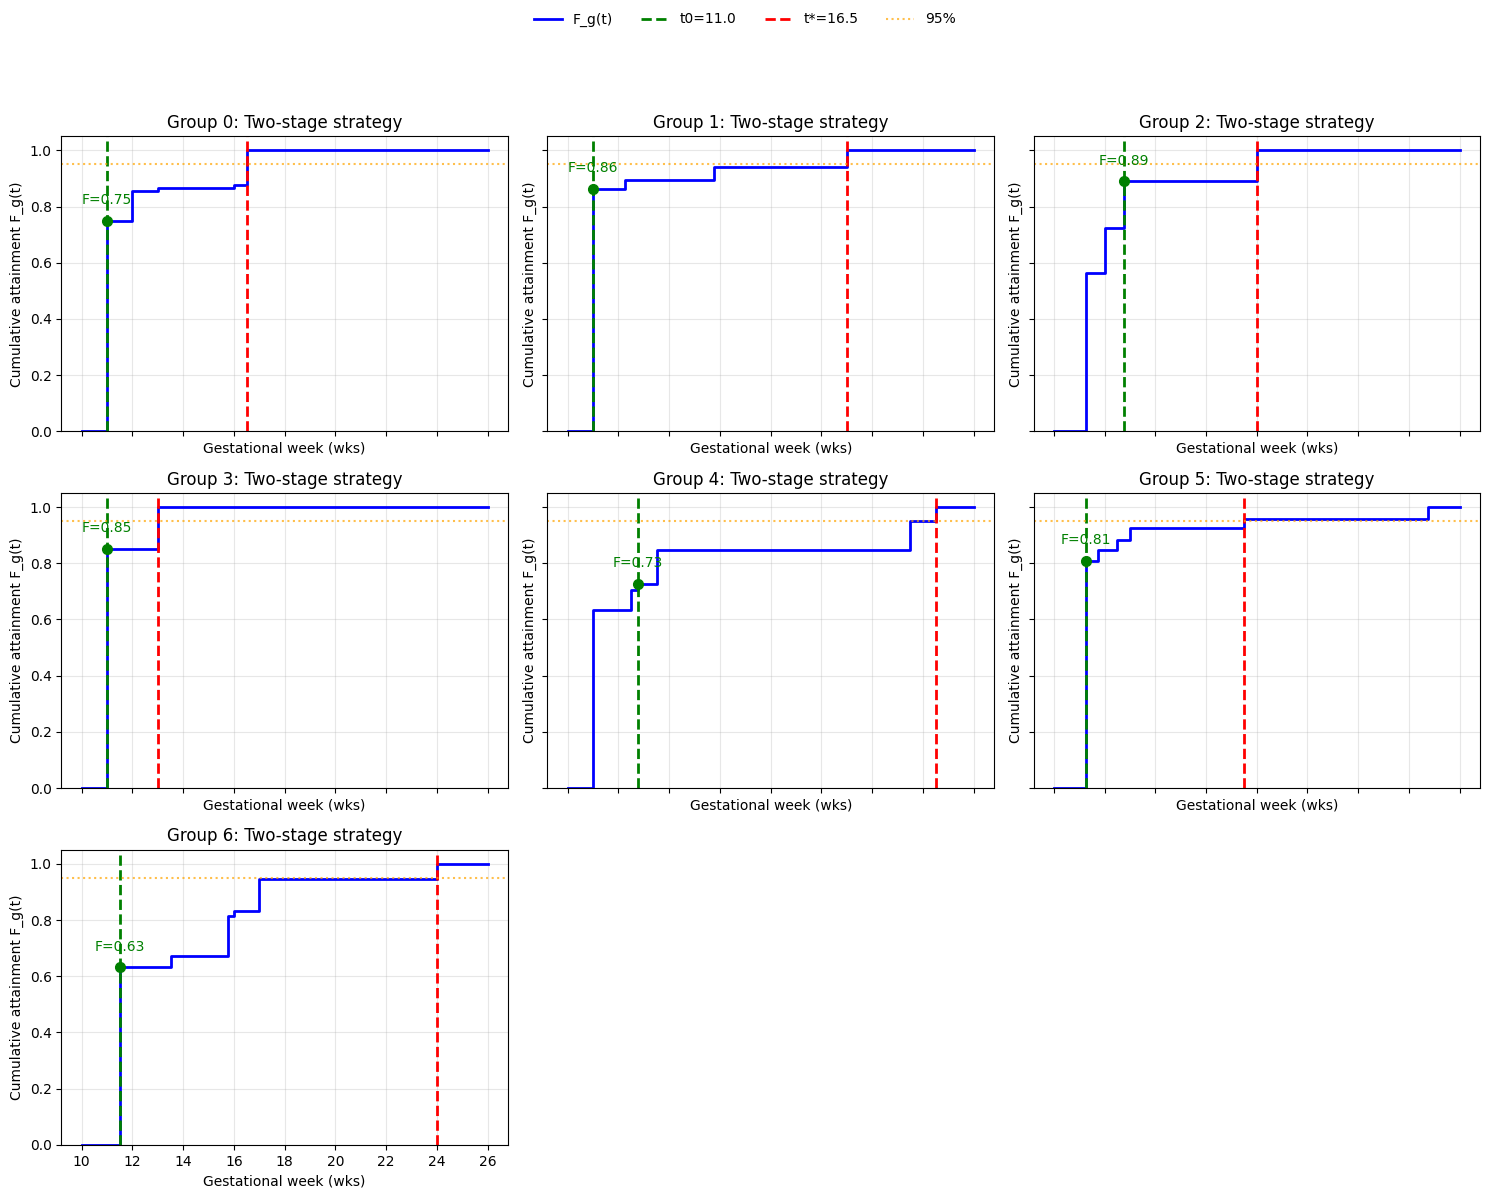

In [13]:
import matplotlib.pyplot as plt
# 可视化优化结果
def plot_two_stage_strategy(opt_results: dict, group_surv: dict, t_grid: np.ndarray):
    """绘制两阶段策略可视化图（修复子图网格与轴处理）"""
    
    groups = sorted(opt_results.keys())
    G = len(groups)
    from math import ceil
    ncols = 2 if G <= 6 else 3
    nrows = ceil(G / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True, sharey=True)
    axes = np.atleast_1d(axes).ravel()
    for i, g in enumerate(groups):
        ax = axes[i]
        
        # 获取该组数据
        strategy = opt_results[g]
        res = group_surv[g]
        
        # 计算F_g(t)
        Sg = eval_step_S(t_grid, res["support"], res["S"])
        Fg = 1.0 - Sg
        
        # 绘制F_g(t)曲线
        ax.step(t_grid, Fg, where='post', linewidth=2, label='F_g(t)', color='blue')
        
        # 标记关键时点
        t0 = strategy['t0']
        t_star = strategy['t_star_g']
        F_t0 = strategy['F_t0']
        
        # t0时点
        ax.axvline(t0, color='green', linestyle='--', linewidth=2, label=f't0={t0:.1f}')
        ax.plot([t0], [F_t0], 'go', markersize=7)
        ax.text(t0, min(1.0, F_t0 + 0.06), f'F={F_t0:.2f}', ha='center', color='green')
        
        # t*_g时点  
        ax.axvline(t_star, color='red', linestyle='--', linewidth=2, label=f't*={t_star:.1f}')
        ax.axhline(0.95, color='orange', linestyle=':', alpha=0.7, label='95%')
        # ==== changed: use English texts to avoid CJK rendering issues ====
        ax.set_title(f'Group {int(g)}: Two-stage strategy')
        ax.set_xlabel('Gestational week (wks)')
        ax.set_ylabel('Cumulative attainment F_g(t)')
        # ================================================================
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.05)
    
    # 关闭多余子图
    for k in range(G, len(axes)):
        axes[k].axis('off')
    
    # 合并图例
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=4, frameon=False)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    return fig

# 执行分析
result_summary = analyze_optimization_results(optimization_results, stats)
print("=== 两阶段联合优化结果 ===")
display(result_summary)

# 绘制策略图
fig_strategy = plot_two_stage_strategy(optimization_results, group_surv, t_grid)
plt.show()

## 敏感性分析：成本参数对策略的影响

In [14]:
# 成本参数敏感性分析
def cost_sensitivity_analysis(
    group_surv: dict, 
    stats_df: pd.DataFrame,
    t_grid: np.ndarray,
    pi_star: float = 0.95
):
    """分析不同成本参数组合对最优策略的影响"""
    
    # 定义参数变化范围
    param_scenarios = {
        '保守型': {'w_E': 0.5, 'w_13': 2.0, 'w_28': 3.0, 'lambda_val': 1.5, 'alpha': 0.8},
        '标准型': {'w_E': 1.0, 'w_13': 3.0, 'w_28': 5.0, 'lambda_val': 1.0, 'alpha': 1.0},
        '激进型': {'w_E': 1.5, 'w_13': 4.0, 'w_28': 7.0, 'lambda_val': 0.8, 'alpha': 1.2},
        '成本敏感': {'w_E': 0.8, 'w_13': 1.5, 'w_28': 2.5, 'lambda_val': 2.0, 'alpha': 0.5}
    }
    
    sensitivity_results = {}
    
    for scenario_name, params in param_scenarios.items():
        print(f"\n=== {scenario_name}策略 ===")
        opt_result = two_stage_optimization(
            group_surv, stats_df, t_grid, 
            cost_params=params, pi_star=pi_star
        )
        sensitivity_results[scenario_name] = opt_result
    
    return sensitivity_results

# 执行敏感性分析
sensitivity_results = cost_sensitivity_analysis(group_surv, stats, t_grid, pi_star)

# 对比不同策略
comparison_data = []
for scenario, results in sensitivity_results.items():
    for g, strategy in results.items():
        comparison_data.append({
            '策略类型': scenario,
            '组号': int(g),
            '最优t0': strategy['t0'],
            '期望检测时间': strategy['ET_t0'], 
            '总成本': strategy['total_cost'],
            '早期达标率': strategy['F_t0']
        })

comparison_df = pd.DataFrame(comparison_data)

# 透视表展示
pivot_t0 = comparison_df.pivot_table(
    values='最优t0', index='组号', columns='策略类型', aggfunc='first'
).round(1)

pivot_cost = comparison_df.pivot_table(
    values='总成本', index='组号', columns='策略类型', aggfunc='first'
).round(3)

print("\n=== 不同策略下的最优t0对比(周) ===")
display(pivot_t0)

print("\n=== 不同策略下的总成本对比 ===")
display(pivot_cost)


=== 保守型策略 ===

=== 标准型策略 ===

=== 激进型策略 ===

=== 成本敏感策略 ===

=== 不同策略下的最优t0对比(周) ===


策略类型,保守型,成本敏感,标准型,激进型
组号,,,,
0,11.0,11.0,11.0,11.0
1,11.0,11.0,11.0,11.0
2,12.8,12.8,12.8,12.8
3,11.0,11.0,11.0,11.0
4,11.0,13.5,12.8,12.8
5,11.2,11.2,11.2,11.2
6,11.5,11.5,11.5,11.5



=== 不同策略下的总成本对比 ===


策略类型,保守型,成本敏感,标准型,激进型
组号,,,,
0,18.662,24.850,12.625,10.350
1,18.614,24.800,12.510,10.145
2,20.041,26.707,13.442,10.864
3,17.004,22.652,11.444,9.304
4,24.045,31.196,16.253,13.277
5,18.738,24.959,12.632,10.296
6,24.313,32.368,16.479,13.552


## 实际应用建议生成

In [15]:
# 生成实际应用建议
def generate_practical_recommendations(
    opt_results: dict,
    stats_df: pd.DataFrame, 
    sensitivity_results: dict = None
):
    """生成实际临床应用建议"""
    
    recommendations = []
    
    for g, strategy in opt_results.items():
        group_info = stats_df[stats_df['group'] == g].iloc[0]
        
        # 基础建议
        t0_opt = strategy['t0']
        t_star = strategy['t_star_g'] 
        early_rate = strategy['F_t0']
        
        # 建议分类
        if early_rate >= 0.8:
            advice_level = "推荐"
            risk_note = "早期检测成功率高"
        elif early_rate >= 0.6:
            advice_level = "建议"
            risk_note = "早期检测中等成功率，需关注复测"
        else:
            advice_level = "谨慎"
            risk_note = "早期检测成功率较低，强化复测方案"
        
        # 时间窗口建议
        if t0_opt < 12:
            timing_advice = f"在{t0_opt:.1f}周进行首次检测(早期窗口)"
        elif t0_opt < 16:
            timing_advice = f"在{t0_opt:.1f}周进行首次检测(标准窗口)"
        else:
            timing_advice = f"在{t0_opt:.1f}周进行首次检测(延后窗口)"
        
        recommendations.append({
            '组别': f"组{int(g)}",
            'BMI范围': group_info['bmi_interval'],
            '样本特征': f"N={int(group_info['n'])}, 删失率{group_info['censored_rate']:.1%}",
            '推荐等级': advice_level,
            '首次检测时间': f"{t0_opt:.1f}周",
            '保底检测时间': f"{t_star:.1f}周",
            '早期成功率': f"{early_rate:.1%}",
            '临床建议': f"{timing_advice}，{risk_note}",
            '备注': f"预期节省{t_star-t0_opt:.1f}周检测时间"
        })
    
    rec_df = pd.DataFrame(recommendations)
    
    # 生成总体建议
    overall_advice = f"""
=== 临床实施建议 ===

1. 个性化检测策略：
   - 根据孕妇BMI分组，采用不同的两阶段检测方案
   - 低BMI组: 早期检测时点可适当提前
   - 高BMI组: 早期检测时点需适当推迟，加强保底检测

2. 质量控制要点：
   - 确保早期检测的技术可靠性
   - 建立完善的复测跟踪机制  
   - 设置风险阈值预警系统

3. 成本效益考量：
   - 早期检测可显著减少整体检测时间
   - 需平衡检测成本与临床效果
   - 建议建立动态成本调节机制

4. 实施监控：
   - 定期评估各组实际达标率
   - 监控成本控制效果
   - 根据实际情况调整参数
"""
    
    return rec_df, overall_advice

# 生成应用建议
recommendations_df, overall_advice = generate_practical_recommendations(
    optimization_results, stats, sensitivity_results
)

print("=== 个性化检测方案建议 ===")
display(recommendations_df)

print(overall_advice)

=== 个性化检测方案建议 ===


,组别,BMI范围,样本特征,推荐等级,首次检测时间,保底检测时间,早期成功率,临床建议,备注
0,组0,"(-inf, 29.10]","N=39, 删失率0.0%",建议,11.0周,16.5周,75.0%,在11.0周进行首次检测(早期窗口)，早期检测中等成功率，需关注复测,预期节省5.5周检测时间
1,组1,"(29.10, 29.89]","N=34, 删失率2.9%",推荐,11.0周,21.0周,86.3%,在11.0周进行首次检测(早期窗口)，早期检测成功率高,预期节省10.0周检测时间
2,组2,"(29.89, 30.48]","N=33, 删失率3.0%",推荐,12.8周,18.0周,88.9%,在12.8周进行首次检测(标准窗口)，早期检测成功率高,预期节省5.2周检测时间
3,组3,"(30.48, 31.56]","N=33, 删失率0.0%",推荐,11.0周,13.0周,85.2%,在11.0周进行首次检测(早期窗口)，早期检测成功率高,预期节省2.0周检测时间
4,组4,"(31.56, 32.38]","N=26, 删失率7.7%",建议,12.8周,24.5周,72.5%,在12.8周进行首次检测(标准窗口)，早期检测中等成功率，需关注复测,预期节省11.8周检测时间
5,组5,"(32.38, 34.31]","N=59, 删失率5.1%",推荐,11.2周,17.5周,80.9%,在11.2周进行首次检测(早期窗口)，早期检测成功率高,预期节省6.2周检测时间
6,组6,"(34.31, +inf]","N=43, 删失率4.7%",建议,11.5周,24.0周,63.1%,在11.5周进行首次检测(早期窗口)，早期检测中等成功率，需关注复测,预期节省12.5周检测时间



=== 临床实施建议 ===

1. 个性化检测策略：
   - 根据孕妇BMI分组，采用不同的两阶段检测方案
   - 低BMI组: 早期检测时点可适当提前
   - 高BMI组: 早期检测时点需适当推迟，加强保底检测

2. 质量控制要点：
   - 确保早期检测的技术可靠性
   - 建立完善的复测跟踪机制  
   - 设置风险阈值预警系统

3. 成本效益考量：
   - 早期检测可显著减少整体检测时间
   - 需平衡检测成本与临床效果
   - 建议建立动态成本调节机制

4. 实施监控：
   - 定期评估各组实际达标率
   - 监控成本控制效果
   - 根据实际情况调整参数



In [16]:
def calculate_composite_risk_score(
    opt_results: dict,
    group_surv: dict,
    stats_df: pd.DataFrame,
    t_grid: np.ndarray,
    individual_data: pd.DataFrame = None,
):
    """
    计算综合风险评分 (CRS)

    CRS = α·时间风险 + β·检测风险 + γ·成本风险 + δ·临床风险

    参数:
    - α, β, γ, δ: 权重系数，和为1
    - 时间风险: 基于期望检测时间的标准化分数
    - 检测风险: 基于早期检测失败概率
    - 成本风险: 基于总成本的标准化分数
    - 临床风险: 基于删失率和样本不确定性
    """

    # 权重设置（可根据临床重要性调整）
    weights = {
        "time_risk": 0.3,  # 时间延误风险
        "detection_risk": 0.4,  # 检测失败风险
        "cost_risk": 0.2,  # 经济成本风险
        "clinical_risk": 0.1,  # 临床不确定性风险
    }

    risk_scores = {}
    risk_components = {}

    # 收集各组数据用于标准化
    all_ET = [s["ET_t0"] for s in opt_results.values()]
    all_costs = [s["total_cost"] for s in opt_results.values()]
    all_failure_rates = [1 - s["F_t0"] for s in opt_results.values()]
    all_censored_rates = [
        stats_df[stats_df["group"] == g]["censored_rate"].iloc[0]
        for g in opt_results.keys()
    ]

    # 标准化函数（0-1范围，越高风险越大）
    def normalize_risk(values, reverse=False):
        values = np.array(values)
        if values.std() == 0:
            return np.zeros_like(values)
        normalized = (values - values.min()) / (values.max() - values.min())
        return 1 - normalized if reverse else normalized

    # 标准化各风险指标
    time_risks = normalize_risk(all_ET)  # 期望时间越长风险越高
    detection_risks = np.array(all_failure_rates)  # 失败率本身就是风险
    cost_risks = normalize_risk(all_costs)  # 成本越高风险越高
    clinical_risks = normalize_risk(all_censored_rates)  # 删失率越高不确定性越大

    for i, g in enumerate(sorted(opt_results.keys())):
        # 计算各组件风险分数
        components = {
            "time_risk": float(time_risks[i]),
            "detection_risk": float(detection_risks[i]),
            "cost_risk": float(cost_risks[i]),
            "clinical_risk": float(clinical_risks[i]),
        }

        # 计算综合风险分数
        crs = sum(weights[k] * components[k] for k in weights.keys())

        # 风险等级划分
        if crs <= 0.3:
            risk_level = "低风险"
            risk_color = "green"
        elif crs <= 0.6:
            risk_level = "中等风险"
            risk_color = "orange"
        else:
            risk_level = "高风险"
            risk_color = "red"

        risk_scores[g] = {
            "CRS": float(crs),
            "risk_level": risk_level,
            "risk_color": risk_color,
            "components": components,
        }
        risk_components[g] = components

    return risk_scores, risk_components


def evaluate_model_performance(risk_scores: dict, opt_results: dict):
    """
    基于风险评分评价模型整体性能
    """

    crs_values = [score["CRS"] for score in risk_scores.values()]

    # 模型性能指标
    performance_metrics = {
        "平均风险分数": np.mean(crs_values),
        "风险分数标准差": np.std(crs_values),
        "最高风险分数": np.max(crs_values),
        "最低风险分数": np.min(crs_values),
        "高风险组比例": np.mean(
            [1 if s["CRS"] > 0.6 else 0 for s in risk_scores.values()]
        ),
        "低风险组比例": np.mean(
            [1 if s["CRS"] <= 0.3 else 0 for s in risk_scores.values()]
        ),
    }

    # 模型质量评价
    avg_risk = performance_metrics["平均风险分数"]
    risk_dispersion = performance_metrics["风险分数标准差"]

    if avg_risk <= 0.4 and risk_dispersion <= 0.2:
        model_grade = "优秀"
        model_score = 90 + (1 - avg_risk) * 10
    elif avg_risk <= 0.5 and risk_dispersion <= 0.3:
        model_grade = "良好"
        model_score = 80 + (1 - avg_risk) * 10
    elif avg_risk <= 0.6:
        model_grade = "一般"
        model_score = 70 + (1 - avg_risk) * 10
    else:
        model_grade = "需要改进"
        model_score = max(50, 60 + (1 - avg_risk) * 10)

    performance_metrics["模型评级"] = model_grade
    performance_metrics["模型得分"] = round(model_score, 1)

    return performance_metrics


# 计算综合风险评分
risk_scores, risk_components = calculate_composite_risk_score(
    optimization_results, group_surv, stats, t_grid
)

# 评价模型性能
model_performance = evaluate_model_performance(risk_scores, optimization_results)

print("=== 综合风险评分结果 ===")
risk_summary = []
for g, score_info in risk_scores.items():
    group_stats = stats[stats["group"] == g].iloc[0]
    strategy = optimization_results[g]

    risk_summary.append(
        {
            "组别": f"组{int(g)}",
            "BMI范围": group_stats["bmi_interval"],
            "综合风险分数(CRS)": f"{score_info['CRS']:.3f}",
            "风险等级": score_info["risk_level"],
            "时间风险": f"{score_info['components']['time_risk']:.2f}",
            "检测风险": f"{score_info['components']['detection_risk']:.2f}",
            "成本风险": f"{score_info['components']['cost_risk']:.2f}",
            "临床风险": f"{score_info['components']['clinical_risk']:.2f}",
            "最优t0": f"{strategy['t0']:.1f}周",
            "早期成功率": f"{strategy['F_t0']:.1%}",
        }
    )

risk_summary_df = pd.DataFrame(risk_summary)
display(risk_summary_df)

print("\n=== 模型整体性能评价 ===")
for metric, value in model_performance.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.3f}")
    else:
        print(f"{metric}: {value}")

print(
    f"\n⭐ 模型最终评分: {model_performance['模型得分']}/100 ({model_performance['模型评级']})"
)

=== 综合风险评分结果 ===


,组别,BMI范围,综合风险分数(CRS),风险等级,时间风险,检测风险,成本风险,临床风险,最优t0,早期成功率
0,组0,"(-inf, 29.10]",0.214,低风险,0.22,0.25,0.23,0.00,11.0周,75.0%
1,组1,"(29.10, 29.89]",0.203,低风险,0.22,0.14,0.21,0.38,11.0周,86.3%
2,组2,"(29.89, 30.48]",0.290,低风险,0.42,0.11,0.40,0.39,12.8周,88.9%
3,组3,"(30.48, 31.56]",0.059,低风险,0.00,0.15,0.00,0.00,11.0周,85.2%
4,组4,"(31.56, 32.38]",0.693,高风险,0.97,0.27,0.96,1.00,12.8周,72.5%
5,组5,"(32.38, 34.31]",0.261,低风险,0.24,0.19,0.24,0.66,11.2周,80.9%
6,组6,"(34.31, +inf]",0.708,高风险,1.00,0.37,1.00,0.60,11.5周,63.1%



=== 模型整体性能评价 ===
平均风险分数: 0.347
风险分数标准差: 0.234
最高风险分数: 0.708
最低风险分数: 0.059
高风险组比例: 0.286
低风险组比例: 0.714
模型评级: 良好
模型得分: 86.500

⭐ 模型最终评分: 86.5/100 (良好)
